In [2]:
import trenchripper as tr
import anndata
import urllib.request
import os
import glob
import h5py
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import scanpy as sc
import matplotlib as mpl
import dask.dataframe as dd
import pickle as pkl
import sklearn as skl
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import scipy.cluster.hierarchy as sch

from dna_features_viewer import BiopythonTranslator
from Bio.SeqFeature import SeqFeature,FeatureLocation
from Bio import SeqIO
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull

import goatools
import goatools.base
from goatools.base import download_go_basic_obo

from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader
from goatools.semantic import semantic_similarity
from goatools.semantic import TermCounts, get_info_content

from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.go_enrichment import GOEnrichmentStudy

dask_wd = "/home/de64/scratch/de64/dask"

In [3]:
def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

def label_positive_negative(x,ci_max_controls,ci_min_controls,pval=0.05):
    if (x["Value"]>ci_max_controls)&(x["Corrected P-Value"]<pval):
        return "Positive"
    elif (x["Value"]<ci_min_controls)&(x["Corrected P-Value"]<pval):
        return "Negative"
    else:
        return "Neither"
        
def lookup_variant(variant_library_path,channel,varid,trench_indices):
    path_prefix = variant_library_path + "/" + str(varid) + "_"
    variant_files = glob.glob(path_prefix + '*')
    n_files = len(variant_files)
    img_arr = []
    for i in range(n_files):
        variant_file = path_prefix + str(i) + ".hdf5"
        with h5py.File(variant_file,"r") as infile:
            data = infile[channel][trench_indices]
            img_arr.append(data)
    img_arr = np.concatenate(img_arr,axis=1)
    return img_arr
    
def make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange,\
                      extra_highlight_category = None,\
                      control_categories = ['OnlyPlasmid', 'NoTarget'],sigma_vbars=3,figsize=(6,5),\
                     positive_color="tab:green",negative_color="tab:purple",noeffect_color="grey",\
                      control_color="tab:orange",extra_category_color="tab:blue",highlighted_outline_width=1):
    ex_df = ss_estimator_df.loc[param]
    if extra_highlight_category != None:
        ex_df_highlighted_category = ex_df[ex_df[extra_highlight_category]]
        ex_df = ex_df[~ex_df[extra_highlight_category]]
        highlighted_sgrna_list_in_category = [sgrnaid for sgrnaid in highlighted_sgrna_list if sgrnaid in ex_df_highlighted_category.index.tolist()]
        highlighted_sgrna_list = [sgrnaid for sgrnaid in highlighted_sgrna_list if sgrnaid not in ex_df_highlighted_category.index.tolist()]
    
    ex_df_controls = ex_df[ex_df["Category"].isin(control_categories)]
    ex_df_nocontrols = ex_df[~ex_df["Category"].isin(control_categories)]
    ci_max_controls = np.mean(ex_df_controls["Value"]) + 3*np.std(ex_df_controls["Value"])
    ci_min_controls = np.mean(ex_df_controls["Value"]) - 3*np.std(ex_df_controls["Value"])
    ex_df_nocontrols["Volcano State"] = ex_df_nocontrols.apply(lambda x: label_positive_negative(x,ci_max_controls,ci_min_controls), axis=1)
    ex_df_highlighted = ex_df_nocontrols.loc[highlighted_sgrna_list]
    ex_df_controls_highlighted = ex_df_controls.loc[[highlighted_control]]

    max_log_FDR = np.max(ex_df[r"$-log_{10} FDR$"])

    fig,ax = plt.subplots(1,1,figsize=figsize)
    
    ci_max_controls = np.mean(ex_df_controls["Value"]) + sigma_vbars*np.std(ex_df_controls["Value"])
    ci_min_controls = np.mean(ex_df_controls["Value"]) - sigma_vbars*np.std(ex_df_controls["Value"])
    
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Neither")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.03, color=noeffect_color,linewidth=0.5, s=80, zorder=-20)
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Positive")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.2, color=positive_color,linewidth=0.5, s=80, zorder=-19)
    sns.scatterplot(data=ex_df_nocontrols[(ex_df_nocontrols["Volcano State"]=="Negative")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.2, color=negative_color,linewidth=0.5, s=80, zorder=-18)
    sns.scatterplot(data=ex_df_controls,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.5, color=control_color,linewidth=0.5, s=80, zorder=-15)
    
    sns.scatterplot(data=ex_df_controls_highlighted,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color=control_color,linewidth=highlighted_outline_width, s=80, zorder=-14)
    sns.scatterplot(data=ex_df_highlighted[(ex_df_highlighted["Volcano State"]=="Positive")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color=positive_color,linewidth=highlighted_outline_width, s=80, zorder=-15)
    sns.scatterplot(data=ex_df_highlighted[(ex_df_highlighted["Volcano State"]=="Negative")],x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color=negative_color,linewidth=highlighted_outline_width, s=80, zorder=-14)

    if extra_highlight_category != None:
        ex_df_highlighted_category_nocontrols = ex_df_highlighted_category[~ex_df_highlighted_category["Category"].isin(control_categories)]
        ex_df_highlighted_category_highlighted = ex_df_highlighted_category_nocontrols.loc[highlighted_sgrna_list_in_category]
        sns.scatterplot(data=ex_df_highlighted_category_nocontrols,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="white", alpha=0.5, color=extra_category_color,linewidth=0.5, s=80, zorder=-16)
        sns.scatterplot(data=ex_df_highlighted_category_highlighted,x="Value",y=r"$-log_{10} FDR$", ax=ax, edgecolor="black", alpha=1, color=extra_category_color,linewidth=highlighted_outline_width, s=80, zorder=-13)
        
    ax.set_yticks(ticks=[0,1,2,3,max_log_FDR],labels=["0","1","2","3",r"$\geq$" + "{:.2f}".format(max_log_FDR)],fontsize=16,minor=False)
    ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
    ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
    ax.set_xlabel(param_label,fontsize=18)
    ax.set_ylabel(r"$-log_{10} FDR$",fontsize=18)
    
    # Manually set the position of the y-axis label
    # The position is specified as (x, y) in axis coordinates (where 0 is the bottom, 1 is the top for y)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
    ax.vlines([ci_min_controls,ci_max_controls],-0.05,max_log_FDR+0.2,linestyle="--",color="black",linewidth=1.5)
    ax.hlines([-np.log10(0.05)],xrange[0],xrange[1],linestyle="--",color="black",linewidth=1.5)
    ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
    ax.set_ylim(0,max_log_FDR+0.2)
    ax.set_xlim(xrange[0],xrange[1])
    sns.despine(right=True,top=True)

    if extra_highlight_category != None:
        ex_df_highlighted = pd.concat([ex_df_highlighted,ex_df_highlighted_category_highlighted],axis=0)
        ex_df_highlighted = ex_df_highlighted.sort_values("Value")
        print(ex_df_highlighted["Gene"])
    return fig,ax,ex_df_highlighted
# ax.set_xscale("log")
# plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2023-04-05_Multi_Dataset_Figures/S32/Test.png",transparent=True,dpi=500,bbox_inches="tight")

In [4]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://current.geneontology.org/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

divisome_genes = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:1990586")

  EXISTS: go-basic.obo
requests.get(http://current.geneontology.org/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:01.230308  58,540 annotations READ: ./ecocyc.gaf 
Searching for divisome complex


In [5]:
variant_library_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/Variant_Library"
base_export_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S4"

min_n_obervations = 5

ss_estimator_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimator_df = ss_estimator_df[ss_estimator_df.apply(lambda x: np.nanmin([x["N Observations"],x["N Observations Proliferating"]]), axis=1)>=min_n_obervations]
ss_estimator_df = ss_estimator_df.loc["Mean (Robust)"]
ss_estimator_df[r"$-log_{10} FDR$"] = -np.log10(ss_estimator_df["Corrected P-Value"])

#hack to fix units
time_df = ss_estimator_df.loc[["Delta time (s)"]]
time_df["Value"] = time_df["Value"]/3600
time_df["Estimator Variance"] = time_df["Estimator Variance"]/(3600**2)
time_df["CI Width"] = time_df["Estimator Variance"]/3600
time_df = time_df.rename(index={"Delta time (s)":"Delta time (hr)"})
ss_estimator_df = pd.concat([time_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Delta time (s)"]))]], axis=0)

growth_df = ss_estimator_df.loc[["Instantaneous Growth Rate: Volume"]]
growth_df["Value"] = growth_df["Value"]/np.log(2)
growth_df["Estimator Variance"] = growth_df["Estimator Variance"]/(np.log(2)**2)
growth_df["CI Width"] = growth_df["Estimator Variance"]/np.log(2)
ss_estimator_df = pd.concat([growth_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Instantaneous Growth Rate: Volume"]))]], axis=0)

sept_df = ss_estimator_df.loc[["Septum Displacement Length Normalized"]]
sept_df["Value"] = sept_df["Value"]*100
sept_df["Estimator Variance"] = sept_df["Estimator Variance"]*(100**2)
sept_df["CI Width"] = sept_df["Estimator Variance"]*100
ss_estimator_df = pd.concat([sept_df,ss_estimator_df.loc[list(set(ss_estimator_df.index.get_level_values(0).unique())-set(["Septum Displacement Length Normalized"]))]], axis=0)

var_to_gene_series = ss_estimator_df.reset_index().groupby("oDEPool7_id")["Gene"].first()

ss_estimator_df["Divisome"] = ss_estimator_df["Gene"].isin(divisome_genes)

## Figure S4A

In [6]:
#style for kymographs
vmin = 300
vmax = 6000
t_step = 1
t_i = 45
t_f = 60
channel="mCherry"

scale_bar_size_um = 10
scale_bar_thickness = 4
scalebar_color = 'white'  # Color of the scale bar
scalebar_y_position = 320 # Y-position of the scale bar in data units
scalebar_x_position = 240  # X-position of the scale bar in data units
pixel_microns = 0.2125 # Number of microns per pixel for this experiment (can also find in metadata.hdf5)
scale_bar_size_pixels = scale_bar_size_um//pixel_microns
scalebar_on = True

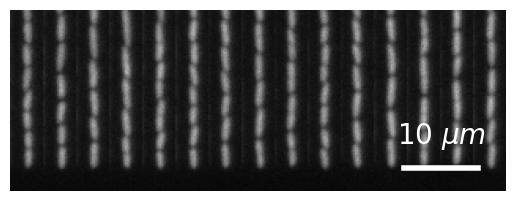

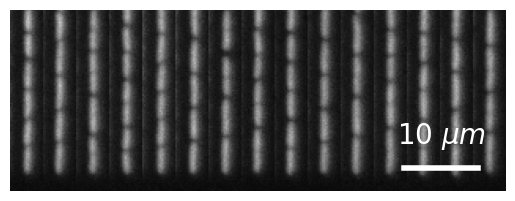

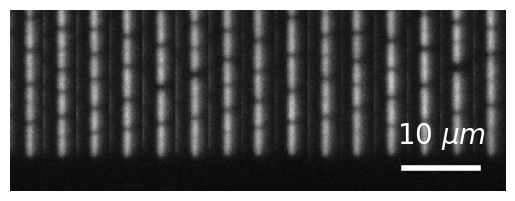

In [7]:
highlighted_df_sgrna_index = [29637,29661,29675]
highlighted_trenches_lists = [[0],[0],[0]]

scalebar_y_position_temp = 100 # Y-position of the scale bar in data units
scalebar_x_position_temp = 250  # X-position of the scale bar in data units

# tr.writedir(base_export_path + "/Controls",overwrite=True)
for i in range(len(highlighted_df_sgrna_index)):
    highlighted_sgrna_idx = highlighted_df_sgrna_index[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[i],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=1)
    gene_name = str(highlighted_df_sgrna_index[i])
    
    tr.plot_kymograph(variant_concat_arr[:,::][t_i:t_f:t_step],vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position_temp, scalebar_x_position_temp + scale_bar_size_pixels],
                [scalebar_y_position_temp, scalebar_y_position_temp],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position_temp + scale_bar_size_pixels / 2,
                scalebar_y_position_temp-30,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
    plt.savefig(base_export_path + "/Controls/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure 4B

/tmp/ipykernel_6479/3005178745.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_6479/3005178745.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])
/tmp/ipykernel_64

oDEPool7_id
1808     alaS
16778    ftsZ
27394    ftsA
13111    ftsL
8889     dnaA
6687     ftsW
28207    folA
9597     ftsN
26644    thyA
6220     rplQ
Name: Gene, dtype: string


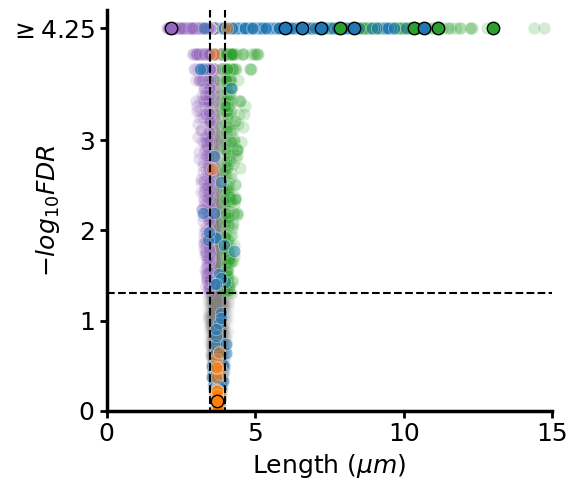

In [29]:
param = "Length"
param_label = "Length ($\mu m$)"

highlighted_sgrna_list = [1808,16778,27394,13111,6687,9597,26644,28207,6220,8889]
highlighted_control = 29662
xrange = (0,15)

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange,extra_highlight_category="Divisome")
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()

plt.savefig(base_export_path + "/Length.png",transparent=True,dpi=500,bbox_inches="tight")

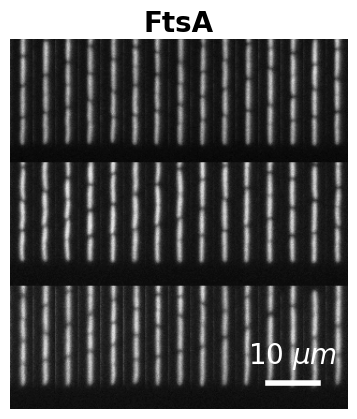

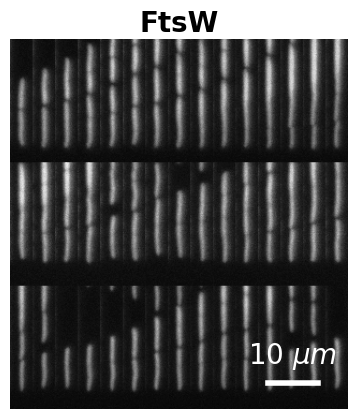

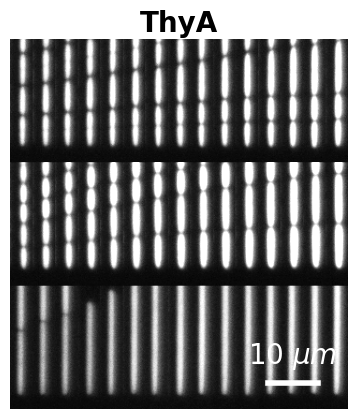

In [30]:
highlighted_sgrna_idx_list = [2,5,8]
highlighted_trenches_lists = [[2,5,6],[2,4,9],[0,2,6]]

tr.writedir(base_export_path + "/Length",overwrite=True)
for i in range(len(highlighted_sgrna_idx_list)):
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=1)
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]
    
    tr.plot_kymograph(variant_concat_arr[:,::][t_i:t_f:t_step],vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/Length/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure 4C

/tmp/ipykernel_6479/2279638161.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_6479/2279638161.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])
/tmp/ipykernel_6

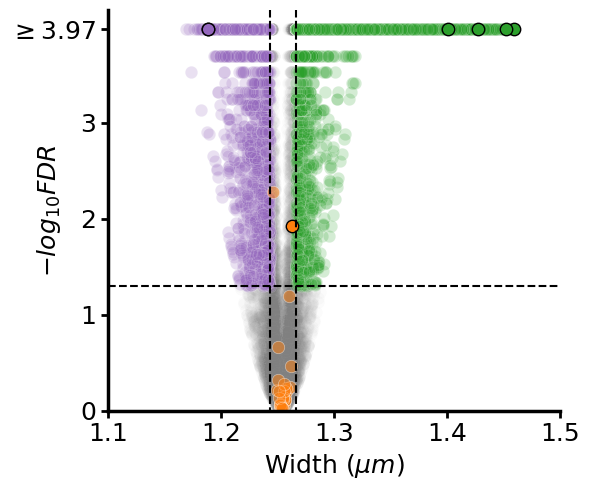

In [31]:
param = "Width"
param_label = "Width ($\mu m$)"

highlighted_sgrna_list = [11977,20417,24395,13079,16712,22509]
highlighted_control = 29662
xrange = (1.1,1.5)

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange,\
                                         extra_highlight_category=None)
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()
plt.savefig(base_export_path + "/Width.png",transparent=True,dpi=500,bbox_inches="tight")

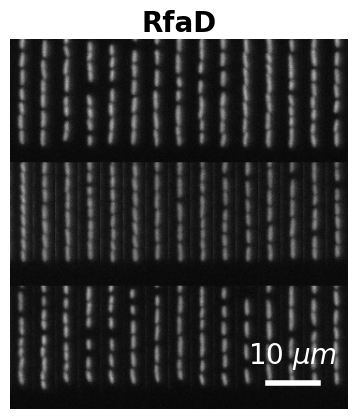

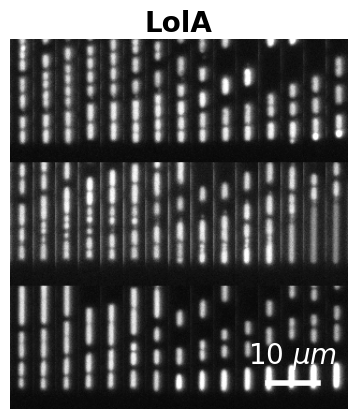

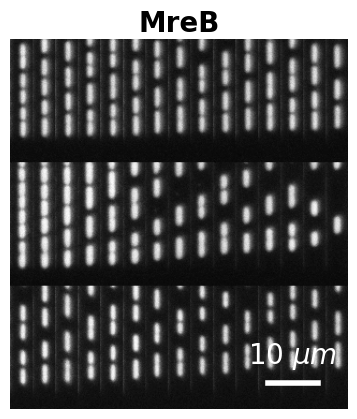

In [32]:
highlighted_sgrna_idx_list = [1,4,5]
highlighted_trenches_lists = [[0,5,6],[1,6,7],[0,1,7]]

tr.writedir(base_export_path + "/Width",overwrite=True)
for i in range(len(highlighted_sgrna_idx_list)):
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=1)
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]
    
    tr.plot_kymograph(variant_concat_arr[:,::][t_i:t_f:t_step],vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/Width/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure 4D

/tmp/ipykernel_6479/735072460.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_6479/735072460.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])
/tmp/ipykernel_6479

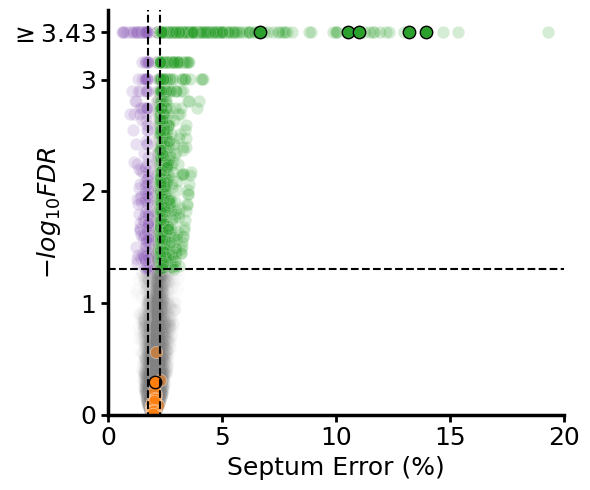

In [33]:
param = "Septum Displacement Length Normalized"
param_label = "Septum Error (%)"

highlighted_sgrna_list = [936,5947,8144,12139,20477]
highlighted_control = 29662
xrange = (0,20)

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange)
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()
plt.savefig(base_export_path + "/Septum_Error.png",transparent=True,dpi=500,bbox_inches="tight")

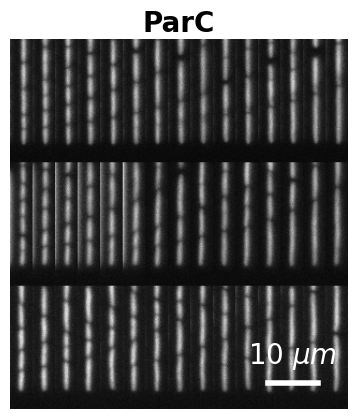

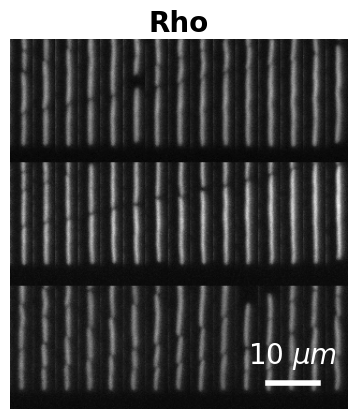

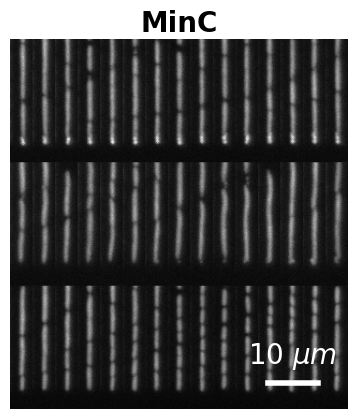

In [34]:
highlighted_sgrna_idx_list = [0,2,3]
highlighted_trenches_lists = [[0,5,6],[0,2,3],[0,3,5]]

tr.writedir(base_export_path + "/Septum_Error",overwrite=True)
for i in range(len(highlighted_sgrna_idx_list)):
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=1)
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]
    
    tr.plot_kymograph(variant_concat_arr[:,::][t_i:t_f:t_step],vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/Septum_Error/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure 4E

/tmp/ipykernel_6479/3040660926.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_6479/3040660926.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])
/tmp/ipykernel_64

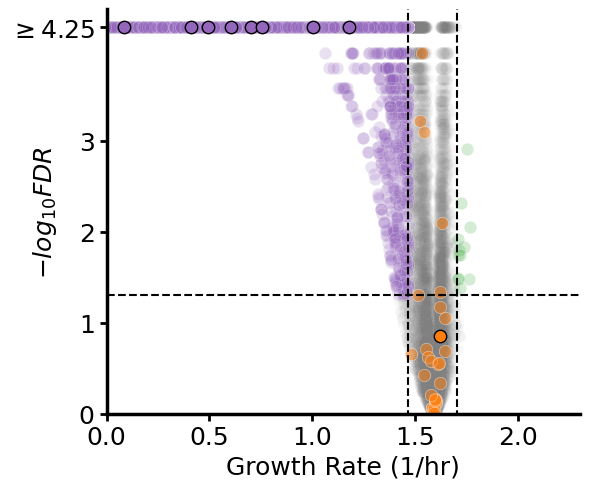

In [24]:
param = "Instantaneous Growth Rate: Volume"
param_label = "Growth Rate (1/hr)"

highlighted_sgrna_list = [20319,23029,2578,4621,9217,20913,903,5357]
highlighted_control = 29662
xrange = (0,2.3)

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange)
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()

plt.savefig(base_export_path + "/Growth_Rate.png",transparent=True,dpi=500,bbox_inches="tight")

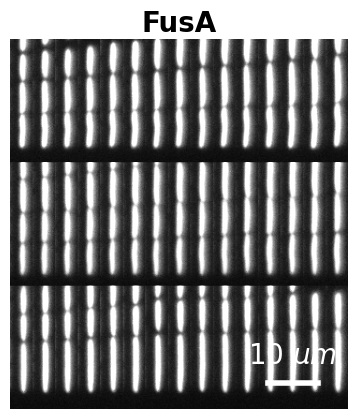

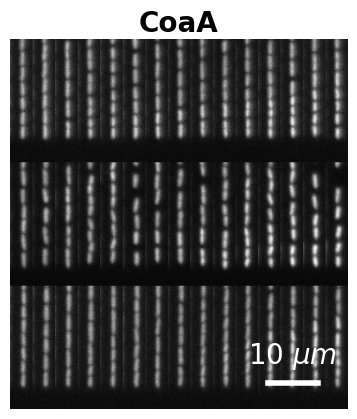

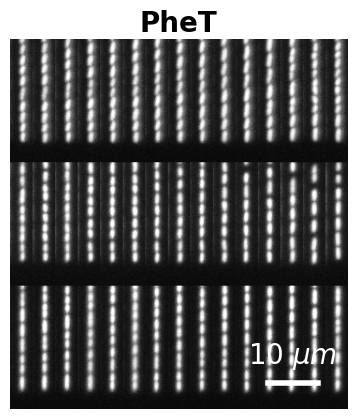

In [25]:
highlighted_sgrna_idx_list = [0,1,4]
highlighted_trenches_lists = [[1,2,3],[0,2,3],[1,2,4]]

tr.writedir(base_export_path + "/Growth_Rate",overwrite=True)
for i in range(len(highlighted_sgrna_idx_list)):
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=1)
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]
    
    tr.plot_kymograph(variant_concat_arr[:,::][t_i:t_f:t_step],vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/Growth_Rate/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure 4F

/tmp/ipykernel_6479/451305121.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_6479/451305121.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])
/tmp/ipykernel_6479

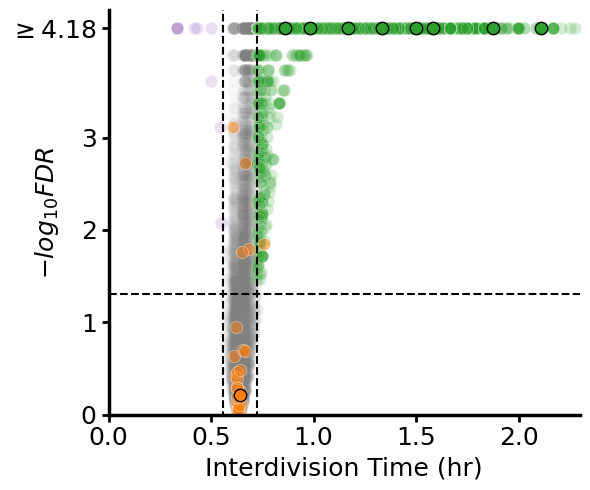

In [26]:
param = "Delta time (hr)"
param_label = "Interdivision Time (hr)"

highlighted_sgrna_list = [23029,2578,4621,9217,20913,13779,903,5357]
highlighted_control = 29662
xrange = (0,2.3)

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange)
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()

plt.savefig(base_export_path + "/Interdivision_Time.png",transparent=True,dpi=500,bbox_inches="tight")

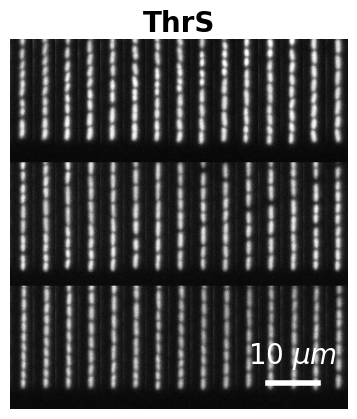

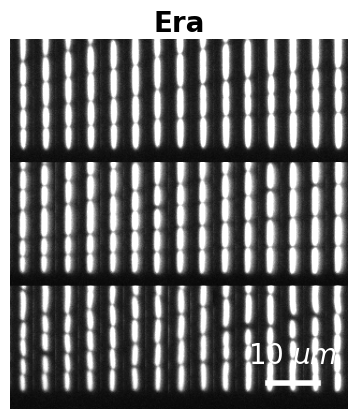

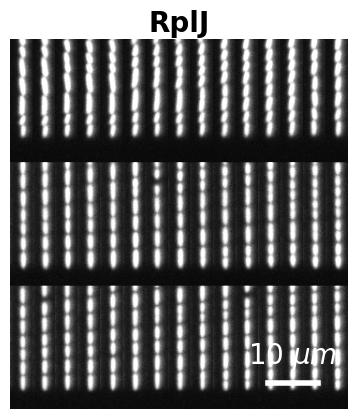

In [27]:
highlighted_sgrna_idx_list = [1,6,7]
highlighted_trenches_lists = [[0,1,3],[0,2,7],[1,2,4]]

tr.writedir(base_export_path + "/Interdivision_Time",overwrite=True)
for i in range(len(highlighted_sgrna_idx_list)):
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=1)
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]
    
    tr.plot_kymograph(variant_concat_arr[:,::][t_i:t_f:t_step],vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/Interdivision_Time/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure 4G

/tmp/ipykernel_6479/1392784776.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
/tmp/ipykernel_6479/1392784776.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])
/tmp/ipykernel_64

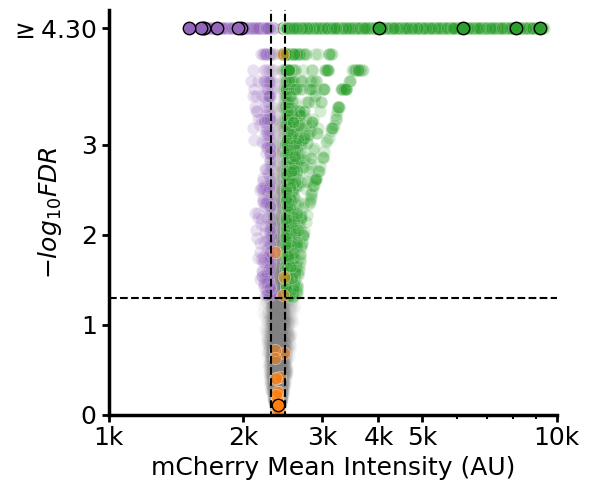

In [35]:
param = "mCherry mean_intensity"
param_label = "mCherry Mean Intensity (AU)"

highlighted_sgrna_list = [25882,15891,20991,10299,8868,22575,16152,5643,21328,4926,19994]
highlighted_control = 29662
xrange = (1000,10000)

ss_estimator_df_subset = ss_estimator_df.loc[param]
max_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmax(x["Value"])])
min_val_df = ss_estimator_df_subset.reset_index().groupby("Gene").apply(lambda x: x.iloc[np.argmin(x["Value"])])

fig,ax,highlighted_df = make_volcano_plot(ss_estimator_df,param,param_label,highlighted_sgrna_list,highlighted_control,xrange)
ax.set_xscale("log")
ax.set_xticks([1000,2000,3000,4000,5000,10000],["1k","2k","3k","4k","5k","10k"])
highlighted_df_sgrna_index = highlighted_df.index.tolist()
highlighted_gene_list = highlighted_df["Gene"].tolist()
plt.tight_layout()
plt.savefig(base_export_path + "/mCherry_Intensity.png",transparent=True,dpi=500,bbox_inches="tight")

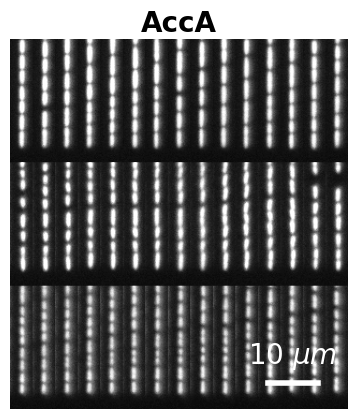

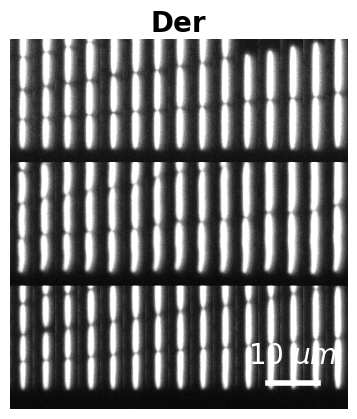

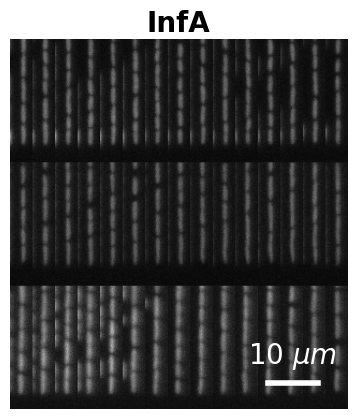

In [36]:
highlighted_sgrna_idx_list = [0,1,9]
highlighted_trenches_lists = [[2,5,6],[1,3,6],[2,3,5]]

tr.writedir(base_export_path + "/mCherry_Intensity",overwrite=True)
for i in range(len(highlighted_sgrna_idx_list)):
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[i]
    highlighted_trenches_list = highlighted_trenches_lists[i]
    
    variant_arr = lookup_variant(variant_library_path,channel,highlighted_df_sgrna_index[highlighted_sgrna_idx],highlighted_trenches_list)
    variant_concat_arr = np.concatenate([variant_arr[i,:,30:145] for i in range(variant_arr.shape[0])], axis=1)
    gene_name = highlighted_gene_list[highlighted_sgrna_idx]
    
    tr.plot_kymograph(variant_concat_arr[:,::][t_i:t_f:t_step],vmin=vmin,vmax=vmax)
    # plt.ylim(135,30)
    plt.axis('off')
    
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-40,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:],fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/mCherry_Intensity/" + gene_name + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()